## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

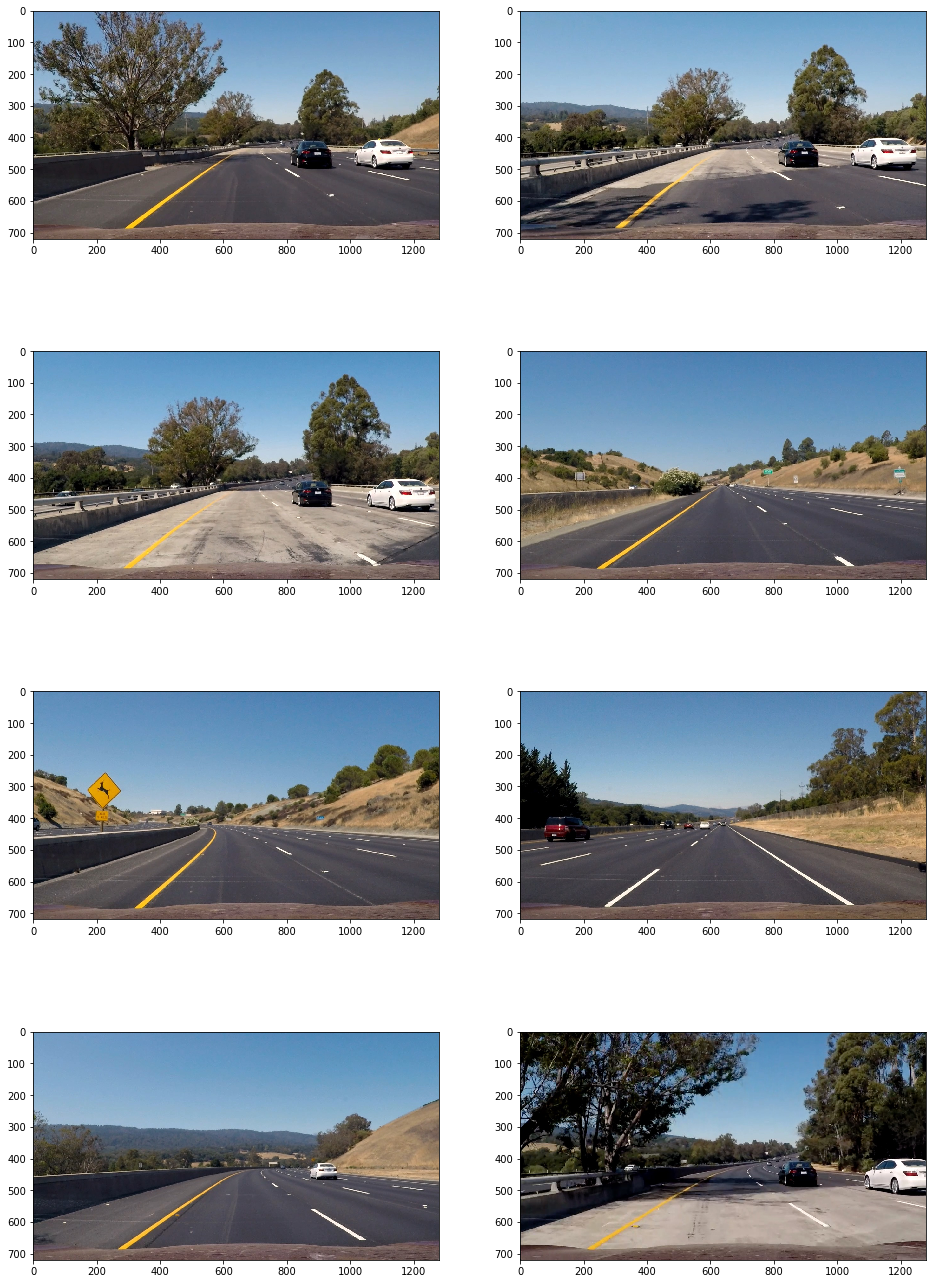

In [50]:
import os
test_images = os.listdir("shadows/")

fig=plt.figure(figsize=(16, 24))
for idx, img_name in enumerate(test_images):
    frame = mpimg.imread("shadows/"+img_name)
    fig.add_subplot(4, 2, idx+1)
    plt.imshow(frame, cmap='Greys_r')
    
def process_images(action):
    fig=plt.figure(figsize=(16, 24))
    for idx, img_name in enumerate(test_images):
        frame = mpimg.imread("shadows/"+img_name)
        masked = action(frame)
        fig.add_subplot(4, 2, idx+1)
        plt.imshow(masked, cmap='Greys_r')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

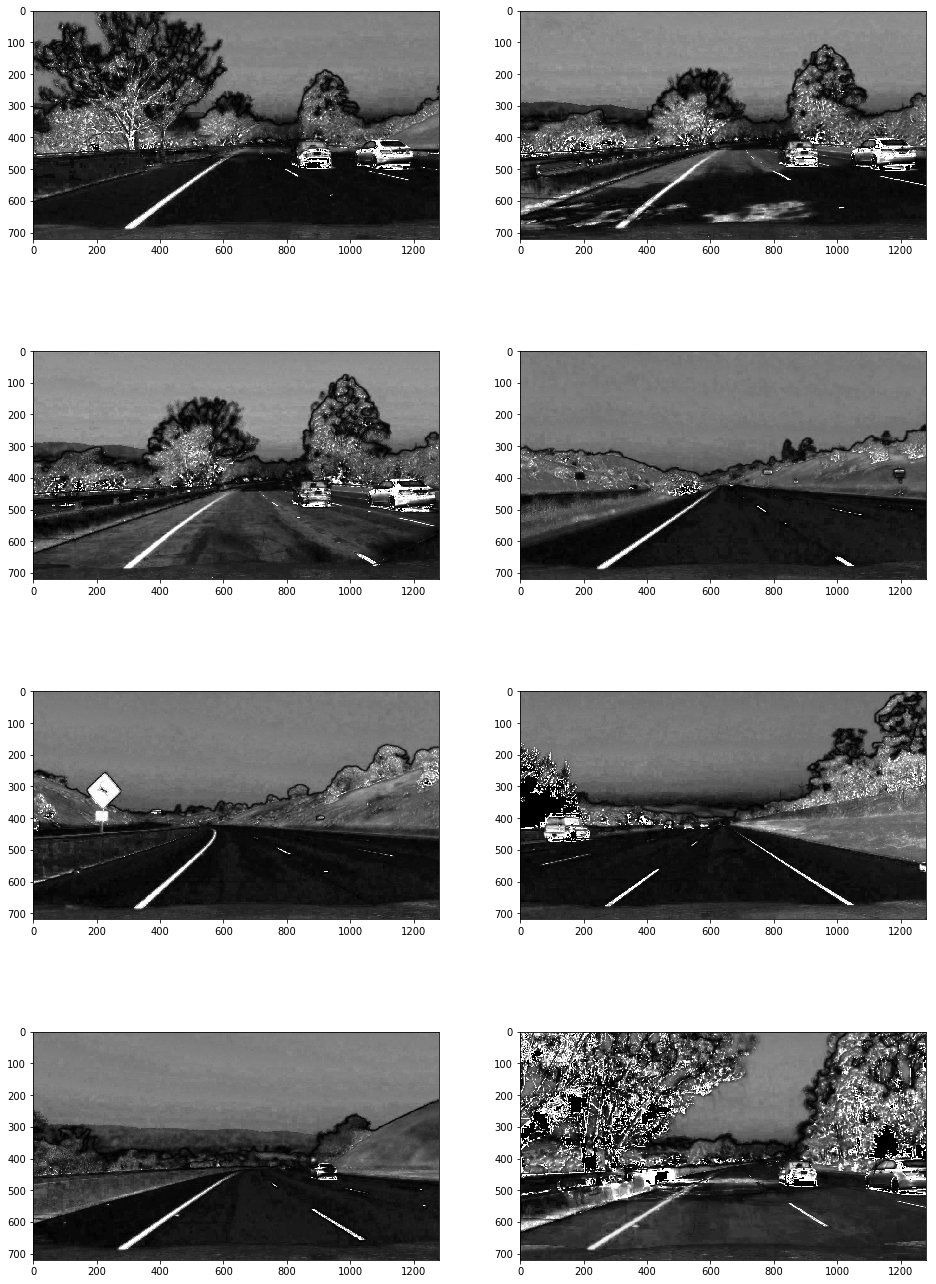

In [51]:
def test_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    return hsv[:, :, 2]

process_images(lambda img: test_hsv(img))
    

# Canny for HLS

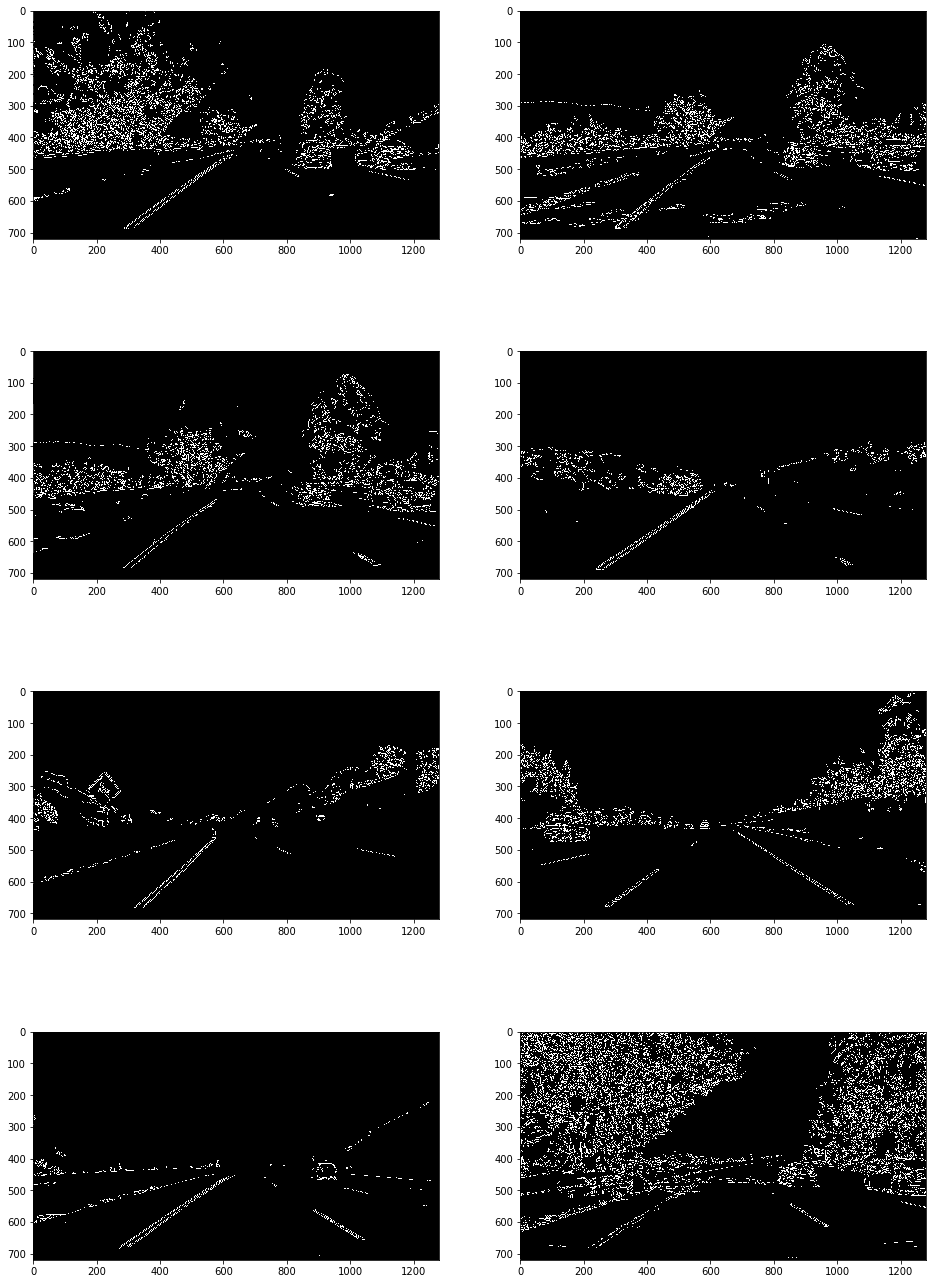

In [54]:
def apply_3_canny(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    edges_hue = canny(hls[:, :, 0], 64, 255)
    edges_light = canny(hls[:, :, 1], 64, 126)
    edges_sat = canny(hls[:, :, 2], 64, 300)
        
    return edges_sat

process_images(lambda img: apply_3_canny(img))

# Region of interest

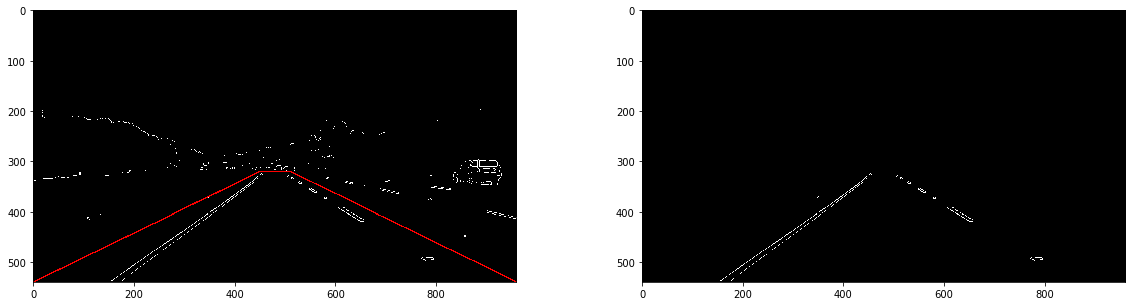

In [123]:
def create_region(image):
    reg_bottom_width = image.shape[1]
    reg_top_width = 60
    reg_height = 320
    
    top_width_diff = (image.shape[1] - reg_top_width) /2
    bottom_left = [0, image.shape[0]]
    bottom_right = [image.shape[1], image.shape[0]]
    top_left=[top_width_diff, reg_height]
    top_right = [image.shape[1] - top_width_diff, reg_height]
    pts = np.array([bottom_left,top_left,top_right,bottom_right], np.int32)
    return [pts]

def apply_region(image):
    vertices = create_region(image)
    masked_region = region_of_interest(image, vertices)
    return masked_region

image = mpimg.imread(test_image_path)
vertices = create_region(image)
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
canvas = np.repeat(apply_3_canny(image)[:, :, np.newaxis], 3, axis=2)
cv2.polylines(canvas, vertices, False, color=[255, 0, 0], thickness=2)
plt.imshow(canvas, cmap='Greys_r')
fig.add_subplot(1, 2, 2)
plt.imshow(apply_region(apply_3_canny(image)), cmap='Greys_r')


# Hough lines

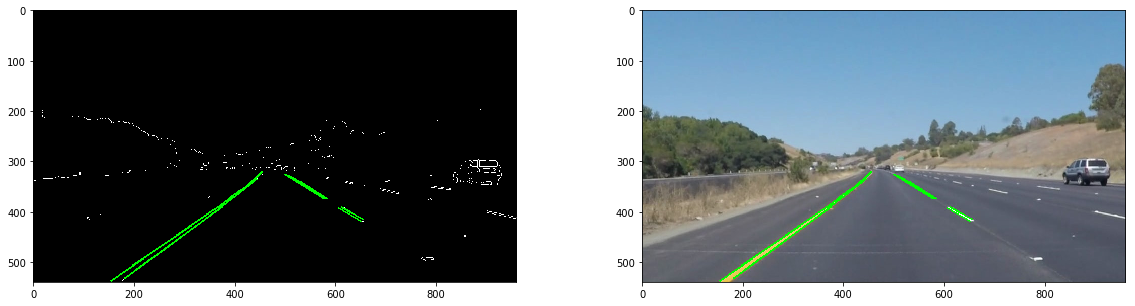

In [133]:
def apply_hough(image):
    lines = cv2.HoughLinesP(image, 2, 2*np.pi/180, 35, np.array([]), minLineLength=20, maxLineGap=20)
    return lines
def draw_hough_lines(image, lines, color=[255, 0, 0]):
    draw_lines(image, lines, color=color, thickness=2)
    return image

image = mpimg.imread(test_image_path)
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
canvas = np.repeat(apply_3_canny(image)[:, :, np.newaxis], 3, axis=2)
edges = draw_hough_lines(canvas, apply_hough(apply_region(apply_3_canny(image))), color=[0, 255, 0])
plt.imshow(edges, cmap='Greys_r')

fig.add_subplot(1, 2, 2)
clean = draw_hough_lines(image, apply_hough(apply_region(apply_3_canny(image))), color=[0, 255, 0])
plt.imshow(clean, cmap='Greys_r')

#process_test_images(lambda image: draw_hough_lines(image, apply_hough(apply_region(apply_3_canny(image)))))

# Extrapolated rulers

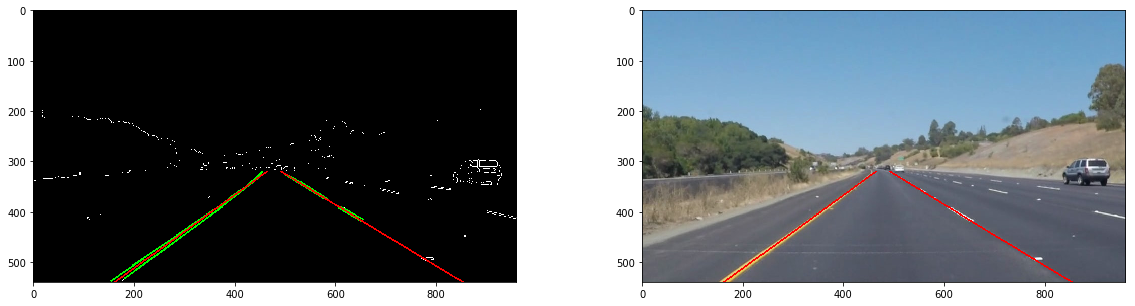

In [136]:
def extrapolate(image, lines, color=[255, 0, 0]):
    canvas = np.zeros_like(image[:, :, 0])
    draw_hough_lines(canvas, lines)
    line_points_row, line_points_col = np.nonzero(canvas)
    if line_points_row.size==0:
        return
    extrapolated = np.polyfit(line_points_row, line_points_col, 1)
    poly = np.poly1d(extrapolated)
    height = image.shape[0]
    low_x, top_x = (poly(height), poly(320))
    cv2.line(image, (int(low_x), height), (int(top_x), 320), color, thickness=2)

def draw_hough_lines_ext(image, lines, color=[255, 0, 0]):
    dx = lines[:, :, 2] - lines[:, :, 0]
    dy = lines[:, :, 3] - lines[:, :, 1]
    tan = dy/dx
    
    right_candidates = tan > 0.5
    left_candidates = tan < -0.5
    right_lines = lines[right_candidates].reshape(-1, 1 ,4)
    left_lines = lines[left_candidates].reshape(-1, 1 ,4)
    extrapolate(image, right_lines, color)
    extrapolate(image, left_lines, color)
    
    return image


image = mpimg.imread(test_image_path)
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
canvas = np.repeat(apply_3_canny(image)[:, :, np.newaxis], 3, axis=2)
edges = draw_hough_lines(canvas, apply_hough(apply_region(apply_3_canny(image))), color=[0, 255, 0])
edges = draw_hough_lines_ext(edges, apply_hough(apply_region(apply_3_canny(image))), color=[255, 0, 0])
plt.imshow(edges, cmap='Greys_r')

fig.add_subplot(1, 2, 2)
clean = draw_hough_lines_ext(image, apply_hough(apply_region(apply_3_canny(image))))
plt.imshow(clean, cmap='Greys_r')

In [86]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def process_pipeline(image):
    result = image
    #result = wy_mask(result)
    result = apply_3_canny(result)
    result = apply_region(result)
    rgb = np.zeros_like(image)
    rgb[:, :, 0] = result
    h_lines = apply_hough(result)
    #h_lines = filter_hough_lines(h_lines)
    #draw_lines(rgb, h_lines, color=[0, 255, 0], thickness=1)
    result = draw_hough_lines_ext(image, h_lines)
    return result#rgb
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [87]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [88]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = process_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [89]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 51.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.31 s, sys: 120 ms, total: 5.43 s
Wall time: 4.69 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [91]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(14,15)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:13<00:00, 49.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.5 s, sys: 476 ms, total: 17 s
Wall time: 14.2 s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [45]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:10<00:00, 26.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.8 s, sys: 248 ms, total: 11.1 s
Wall time: 11 s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))